## Dataset Link: https://www.kaggle.com/manishshah120/facial-expression-recog-image-ver-of-fercdataset

In [1]:
project_name = 'face-exp-resnet'

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [5]:
data_dir = 'C://Users//.lenovo//Face Expression Identifier//Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)
len

['labels.txt', 'test', 'train']
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


<function len(obj, /)>

In [9]:
len(os.listdir(data_dir +'//train//sadness'))

5483

In [10]:
train_tfms = tt.Compose([
#                        tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ColorJitter(brightness=0.1, contrast=0.25, saturation=0.35, hue=0.05),
                         tt.RandomRotation(10, resample=False, expand=False, center=None, fill=None),
                         tt.ToTensor()
                        ])

valid_tfms = tt.Compose([tt.ToTensor()])

In [11]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [12]:
batch_size = 128

In [13]:
train_dl = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
                     )

valid_dl = DataLoader(
    valid_ds, 
    batch_size*2, 
    num_workers=4, 
    pin_memory=True
                     )

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

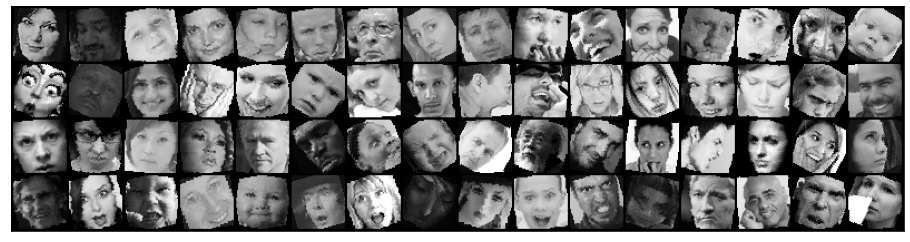

In [15]:
show_batch(train_dl)

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
class ResNet18(ImageClassification):
    def __init__(self, num_classes):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        
    def forward(self, x):
        return self.network(x)

In [21]:
model = ResNet18(7)
model = to_device(model, device)

In [22]:
pip install jovian --upgrade

Note: you may need to restart the kernel to use updated packages.


In [23]:
from tqdm.notebook import tqdm

In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.1447837352752686, 'val_acc': 0.1680208295583725}]

In [26]:
epochs = 25
max_lr = 0.05
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)


  0%|          | 0/253 [00:00<?, ?it/s]

In [28]:
def plot_acc(history):
    acc = [x['val_acc'] for x in history]
    plt.plot(acc,'-x')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. no. of epochs')

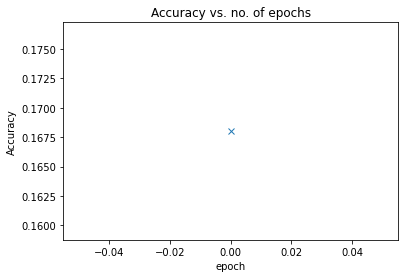

In [29]:
plot_acc(history)

In [27]:
def plot_losses(history):
    train_loss = [x.get('train_loss') for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend('Training', 'Validation')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: http:/

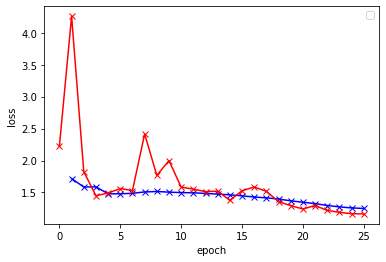

In [28]:
plot_losses(history)

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs',[]) for x in history])
    plt.plot(lrs)
    plt.xlabel('epoch')
    plt.ylabel('learning rate')
    plt.title('Learning Rate vs. no. of epochs')

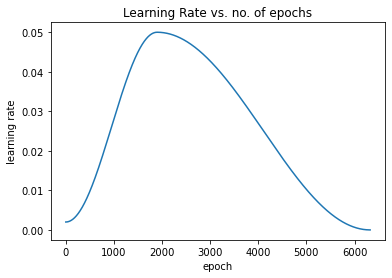

In [30]:
plot_lrs(history)